The following is an application of the following dimensionality reduction algorithm to the Allen Institute 2-P dataset:

D Kobak+, W Brendel+, C Constantinidis, CE Feierstein, A Kepecs, ZF Mainen, X-L Qi, R Romo, N Uchida, CK Machens
Demixed principal component analysis of neural population data
eLife 2016, https://elifesciences.org/content/5/e10989
(arXiv link: http://arxiv.org/abs/1410.6031)

In [1]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities


     |████████████████████████████████| 1.6 MB 7.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 73 kB 1.5 MB/s 
     |████████████████████████████████| 1.7 MB 19.7 MB/s 
     |████████████████████████████████| 3.4 MB 36.1 MB/s 
     |████████████████████████████████| 149 kB 52.4 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 4.3 MB 45.1 MB/s 
     |████████████████████████████████| 48

In [ ]:
pip install dpca

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from dPCA import dPCA

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

In [2]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 1.73MMB/s]
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 5.51MMB/s] 
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 2.16MMB/s] 


In [3]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

In [4]:
experiment_id = experiment_table.query('session_type == "OPHYS_1_images_A"').query('project_code== "VisualBehavior"').sample(random_state=100).index[0]
print('getting experiment data for experiment_id {}'.format(experiment_id))
exp = cache.get_behavior_ophys_experiment(experiment_id)


behavior_ophys_experiment_873972085.nwb:   0%|          | 0.00/728M [00:00<?, ?MB/s]

getting experiment data for experiment_id 873972085


behavior_ophys_experiment_873972085.nwb: 100%|██████████| 728M/728M [00:40<00:00, 18.0MMB/s]


In [5]:
#exp = experiments[ophys_experiment_ids[0]]

hit_change_time = exp.trials[(exp.trials.aborted==False)&(exp.trials.hit==True)].change_time
miss_change_time = exp.trials[(exp.trials.aborted==False)&(exp.trials.miss==True)].change_time
cor_rej_change_time = exp.trials[(exp.trials.aborted==False)&(exp.trials.correct_reject==True)].change_time
false_ala_hit_change_time = exp.trials[(exp.trials.aborted==False)&(exp.trials.false_alarm==True)].change_time

In [6]:
print(len(hit_change_time))
print(len(miss_change_time))
print(len(cor_rej_change_time))
print(len(false_ala_hit_change_time))

150
39
18
8


In [7]:
neural_data = []
for ophys_experiment_id in tqdm([experiment_id]): #tqdm is a package that shows progress bars for items that are iterated over
    
    this_experiment_neural_data = ophys.build_tidy_cell_df(exp)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = exp.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 1/1 [00:15<00:00, 15.04s/it]


In [8]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 85 unique cells
cell ids are: [1086566314, 1086509375, 1086510902, 1086528930, 1086529593, ..., 1086571256, 1086534861, 1086532683, 1086533229, 1086512002]
Length: 85
Categories (85, int64): [1086566314, 1086509375, 1086510902, 1086528930, ..., 1086534861, 1086532683,
                         1086533229, 1086512002]


In [9]:
cell_id = cell_ids[11]
etr = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = hit_change_time,
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
)
etr

,time,dff,event_number,event_time
0,-3.00,-0.032935,0,426.585248
1,-2.98,-0.017502,0,426.585248
2,-2.96,0.005773,0,426.585248
3,-2.94,0.029626,0,426.585248
4,-2.92,0.029960,0,426.585248
...,...,...,...,...
45145,2.92,0.010071,149,3723.291648
45146,2.94,-0.000067,149,3723.291648
45147,2.96,-0.034162,149,3723.291648
45148,2.98,-0.047786,149,3723.291648


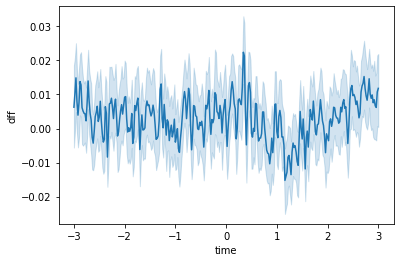

In [ ]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

In [10]:
def make_event_triggered_plot_modified(df, x, y, events_times, ax, t_before=3, t_after=3):
    etr = mindscope_utilities.event_triggered_response(
        data = df,
        t = 'timestamps',
        y = y,
        event_times = events_times,
        t_before=t_before,
        t_after=t_before,
        output_sampling_rate = 50,
    )
    sns.lineplot(
        data=etr,
        x=x,
        y=y,
        n_boot=500,
        ax=ax
    )

100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


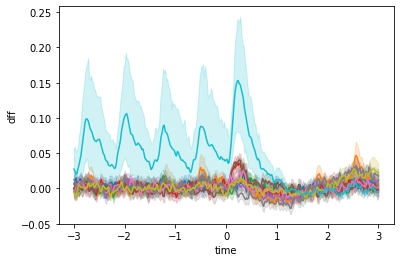

In [ ]:
np.random.seed(2)
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    
    make_event_triggered_plot_modified(
        df = neural_data.query('cell_specimen_id == @cell_id'), 
        x = 'time', 
        y = 'dff', 
        events_times = hit_change_time, 
        ax=ax
    )

100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


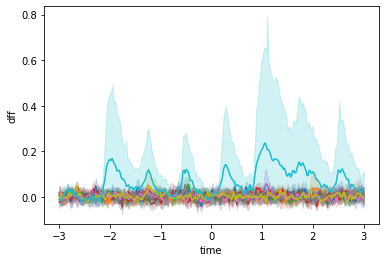

In [ ]:
np.random.seed(2)
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    
    make_event_triggered_plot_modified(
        df = neural_data.query('cell_specimen_id == @cell_id'), 
        x = 'time', 
        y = 'dff', 
        events_times = cor_rej_change_time, 
        ax=ax
    )

In [ ]:
etr

,time,dff,event_number,event_time
0,-3.00,-0.032935,0,426.585248
1,-2.98,-0.017502,0,426.585248
2,-2.96,0.005773,0,426.585248
3,-2.94,0.029626,0,426.585248
4,-2.92,0.029960,0,426.585248
...,...,...,...,...
45145,2.92,0.010071,149,3723.291648
45146,2.94,-0.000067,149,3723.291648
45147,2.96,-0.034162,149,3723.291648
45148,2.98,-0.047786,149,3723.291648


In [13]:
example_row = etr.groupby(['time'])['dff'].mean().reset_index()['dff']
len_row = example_row.shape[0]
len_row

301

In [14]:
#X[n,t,s,d] 
tensor = np.zeros((cell_ids.shape[0],len_row,2,2))
i = 0
for cell_id in tqdm(cell_ids):
  etr11 = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = hit_change_time,
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
  ).groupby(['time'])['dff'].mean().reset_index()['dff']
  etr10 = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = miss_change_time,
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
  ).groupby(['time'])['dff'].mean().reset_index()['dff']
  etr00 = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = cor_rej_change_time,
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
  ).groupby(['time'])['dff'].mean().reset_index()['dff']
  etr01 = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = false_ala_hit_change_time,
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
  ).groupby(['time'])['dff'].mean().reset_index()['dff']
  #print(etr10)
  #print(etr01)
  #print(etr00)
  #print(etr11)
  tensor[i,:,0,0] = etr11
  tensor[i,:,0,1] = etr10
  tensor[i,:,1,0] = etr01
  tensor[i,:,1,1] = etr00
  i+=1


  
    

100%|██████████| 85/85 [01:11<00:00,  1.18it/s]


In [15]:
tensor = (tensor-np.mean(tensor,axis=1,keepdims=True))

In [19]:
dpca = dPCA.dPCA(labels='tsd',regularizer=None)
dpca.protect = ['t']
#dpca.n_trials = 4

In [20]:
Z = dpca.fit_transform(tensor)

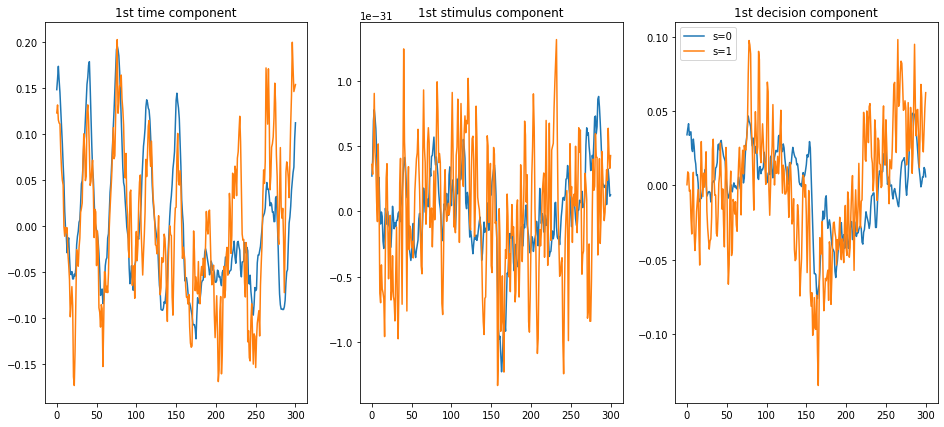

In [23]:
time = np.arange(301)

plt.figure(figsize=(16,7))
plt.subplot(131)
S=2

plt.plot(time,Z['t'][0,:,0,0], label='s=0')
plt.plot(time,Z['t'][0,:,1,0], label='s = 1')

plt.title('1st time component')
    
plt.subplot(132)


plt.plot(time,Z['s'][0,:,0,0], label='0')
plt.plot(time,Z['s'][0,:,1,0], label='1')

plt.title('1st stimulus component')
    
plt.subplot(133)


plt.plot(time,Z['td'][0,:,0,0], label='s=0')
plt.plot(time,Z['td'][0,:,1,0], label='s=1')

    
plt.title('1st decision component')
plt.legend(loc="upper left")
plt.show()